## Importing data

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random

In [2]:
rr_data = pd.DataFrame(pd.read_csv("data/data_RR_merged_20190108.csv"))
m_data = pd.DataFrame(pd.read_csv("data/data_M_merged_20190108.csv"))

In [3]:
# get indices with warmup rounds
rr_indexNames = rr_data[rr_data['round'] == 'warmup'].index
# delete these row indexes from the frame
rr_data.drop(rr_indexNames, inplace=True)

# get indices with warmup rounds
m_indexNames = m_data[m_data['round'] == 'warmup'].index
# delete these row indexes from the frame
m_data.drop(m_indexNames, inplace=True)

In [4]:
# preview rr data
rr_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,permutation,round,level,times_level_played_before,...,costheta,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
6267,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.892647,37.0,0,1,7.009042,10.051521,0.465580,-0.175396,10.063826,0.486787
6268,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.892970,37.0,0,1,7.009042,10.054876,0.492001,-0.189980,10.068699,0.426291
6269,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.895913,37.0,0,1,7.009042,10.057725,0.516986,-0.204504,10.073080,0.366575
6270,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.898400,37.0,0,1,7.009042,10.060076,0.540607,-0.218956,10.076970,0.205269
6271,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.897208,37.0,0,1,7.009042,10.061938,0.562936,-0.233327,10.080374,0.166991


In [5]:
# preview m data
m_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,round,level,times_level_played_before,incorrect,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
5959,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.590391,-1.496124,-9.477220,9.938119,0.096884
5960,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.562202,-1.482067,-9.485622,9.936721,0.086015
5961,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.534205,-1.468358,-9.493919,9.935430,0.111047
5962,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.506382,-1.455013,-9.502127,9.934255,0.091310
5963,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.478715,-1.442047,-9.510264,9.933209,0.055894


In [6]:
# returns values of dictionary in a list
def dict_to_x_y(dictionary):
    x_list = []
    y_list = []
    for key in dictionary:
        x_list.append(dictionary[key][0])
        y_list.append(dictionary[key][1])
    return x_list, y_list

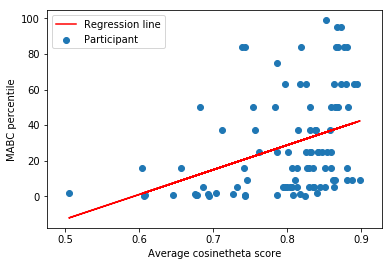

In [7]:
# ID is unique per child
# the higher the costheta score, the better the performance
# mabc_percentile_score is the label associated with the motor skills, again the higher the better

# create a dataframe containing this data
subdata = rr_data[['ID', 'costheta', 'mabc_percentile_score']]

# create a set of all unique children
children_ids = set(subdata['ID'])

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_dictionary = {}
for child_id in children_ids:
    avg_ct = subdata.loc[subdata['ID'] == child_id]['costheta'].mean()
    mabc_perc = subdata.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_dictionary[child_id] = (avg_ct, mabc_perc)
#     print("Child: {} has an avarage costheta score of {} and an MABC percentile equal to {}.".format(child_id, round(avg_ct, 5), round(mabc_perc, 3)))

avg_ct, mabc = dict_to_x_y(subdata_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_ct, mabc)
avg_ct_slope = [i * slope for i in avg_ct]

# scatter plot with mabc
plt.scatter(avg_ct, mabc, label='Participant')
plt.plot(avg_ct, intercept + avg_ct_slope, 'r', label='Regression line')
plt.xlabel("Average cosinetheta score")
plt.ylabel("MABC percentile")
plt.legend()


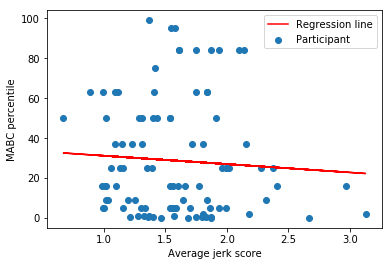

In [8]:
# ID is unique per child
# the higher the costheta score, the better the performance
# mabc_percentile_score is the label associated with the motor skills, again the higher the better

# create a dataframe containing this data
subdata_jerk = rr_data[['ID', 'jerk', 'mabc_percentile_score']]

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_jerk_dictionary = {}
for child_id in children_ids:
    avg_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].mean()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (avg_jerk, mabc_perc)
#     print("Child: {} has an avarage costheta score of {} and an MABC percentile equal to {}.".format(child_id, round(avg_ct, 5), round(mabc_perc, 3)))

avg_jerk, mabc = dict_to_x_y(subdata_jerk_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_jerk, mabc)
avg_jerk_slope = [i * slope for i in avg_jerk]

# scatter plot with mabc
plt.scatter(avg_jerk, mabc, label='Participant')
plt.plot(avg_jerk, intercept + avg_jerk_slope, 'r', label='Regression line')
plt.xlabel("Average jerk score")
plt.ylabel("MABC percentile")
plt.legend()


## Tijd fixen

In [9]:
rr_data_time = rr_data

times = []
for child_id in children_ids:
    child_frame = rr_data.loc[subdata['ID'] == child_id]
    mintime = child_frame['python_tijd'].min()
    fixedtime = child_frame['python_tijd'] - mintime
    times.append(fixedtime.values)
    
    
realtimes = [item for sublist in times for item in sublist]

rr_data_time.insert(4, 'real_time', realtimes)


In [89]:
rr_data_time.head(10)


,ID,index_runner,side_runner,square_runner,real_time,python_tijd,spel,permutation,round,level,...,costheta,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
6267,101,23,2,5,0.00,1.497942e+09,RR,1,level_A,0,...,0.892647,37.0,0,1,7.009042,10.051521,0.465580,-0.175396,10.063826,0.486787
6268,101,23,2,5,0.01,1.497942e+09,RR,1,level_A,0,...,0.892970,37.0,0,1,7.009042,10.054876,0.492001,-0.189980,10.068699,0.426291
6269,101,23,2,5,0.02,1.497942e+09,RR,1,level_A,0,...,0.895913,37.0,0,1,7.009042,10.057725,0.516986,-0.204504,10.073080,0.366575
6270,101,23,2,5,0.02,1.497942e+09,RR,1,level_A,0,...,0.898400,37.0,0,1,7.009042,10.060076,0.540607,-0.218956,10.076970,0.205269
6271,101,23,2,5,0.03,1.497942e+09,RR,1,level_A,0,...,0.897208,37.0,0,1,7.009042,10.061938,0.562936,-0.233327,10.080374,0.166991
6272,101,23,2,5,0.04,1.497942e+09,RR,1,level_A,0,...,0.898858,37.0,0,1,7.009042,10.063323,0.584044,-0.247610,10.083298,0.129659
6273,101,23,2,5,0.05,1.497942e+09,RR,1,level_A,0,...,0.896844,37.0,0,1,7.009042,10.064244,0.604002,-0.261799,10.085751,0.093369
6274,101,23,2,5,0.06,1.497942e+09,RR,1,level_A,0,...,0.896844,37.0,0,1,7.009042,10.064714,0.622877,-0.275889,10.087743,0.069849
6275,101,23,2,5,0.08,1.497942e+09,RR,1,level_A,0,...,0.895630,37.0,0,1,7.009042,10.064747,0.640736,-0.289878,10.089286,0.036418
6276,101,23,2,5,0.09,1.497942e+09,RR,1,level_A,0,...,0.893947,37.0,0,1,7.009042,10.064356,0.657642,-0.303760,10.090393,0.009958


## 012 012 

In [173]:
# kijk naar level_A, n kopier die.
# kijk level_B en kopier die
# kijk level_C en kopier die frame.

# check je frames, vind de gene met 0 bij level  en plak die in new frame.
# 1, 2

# repeat for next levels. 

data_012012 = rr_data_time

data_012012.head()

level012012 = pd.DataFrame() #creates a new dataframe that's empty

for child_id in children_ids:
    child_frame = data_012012.loc[data_012012['ID'] == child_id]
#     print(child_frame)
    level_A = child_frame.loc[child_frame['round'] == 'level_A']
    level_A_level = int(level_A['level'].mean())
    level_B = child_frame.loc[child_frame['round'] == 'level_B']
    level_B_level = int(level_B['level'].mean())
    level_C = child_frame.loc[child_frame['round'] == 'level_C']
    level_C_level = int(level_C['level'].mean())
    level_D = child_frame.loc[child_frame['round'] == 'level_D']
    level_D_level = int(level_D['level'].mean())
    level_E = child_frame.loc[child_frame['round'] == 'level_E']
    level_E_level = int(level_E['level'].mean())
    level_F = child_frame.loc[child_frame['round'] == 'level_F']
    level_F_level = int(level_F['level'].mean())
    
    frames = [level_A, level_B, level_C, level_D, level_E, level_F]
    levels = [level_A_level, level_B_level, level_C_level, level_D_level, level_E_level, level_F_level]
    
    level0 = frames[levels.index(0)]
    level1 = frames[levels.index(1)]
    level2 = frames[levels.index(2)]
    level3 = frames[[i for i, n in enumerate(levels) if n == 0][1]]
    level4 = frames[[i for i, n in enumerate(levels) if n == 1][1]]
    level5 = frames[[i for i, n in enumerate(levels) if n == 2][1]]

    level012012 = level012012.append(level0, ignore_index = True)
    level012012 = level012012.append(level1, ignore_index = True)
    level012012 = level012012.append(level2, ignore_index = True)
    level012012 = level012012.append(level3, ignore_index = True)
    level012012 = level012012.append(level4, ignore_index = True)
    level012012 = level012012.append(level5, ignore_index = True)
    
    print("Done ", child_id)

Done  101
Done  102
Done  103
Done  104
Done  105
Done  107
Done  109
Done  110
Done  111
Done  113
Done  115
Done  116
Done  118
Done  119
Done  120
Done  121
Done  130
Done  131
Done  132
Done  133
Done  134
Done  135
Done  136
Done  190
Done  191
Done  192
Done  193
Done  195
Done  196
Done  197
Done  199
Done  200
Done  201
Done  203
Done  205
Done  207
Done  208
Done  220
Done  221
Done  222
Done  223
Done  225
Done  226
Done  229
Done  230
Done  231
Done  233
Done  234
Done  235
Done  236
Done  237
Done  251
Done  254
Done  255
Done  302
Done  304
Done  307
Done  309
Done  312
Done  314
Done  316
Done  317
Done  318
Done  319
Done  322
Done  324
Done  326
Done  327
Done  328
Done  329
Done  330
Done  332
Done  333
Done  334
Done  336
Done  337
Done  338
Done  339
Done  340
Done  342
Done  343
Done  344
Done  345
Done  346
Done  347
Done  348
Done  349
Done  350
Done  351
Done  352
Done  353
Done  354
Done  355
Done  356
Done  357
Done  358


In [191]:
print("level012012 is a dataset where the level buildup is 012 - 012")
level012012.head(10)

newDF is a dataset where the level buildup is 012 - 012


,ID,index_runner,side_runner,square_runner,real_time,python_tijd,spel,permutation,round,level,...,costheta,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
0,101,23,2,5,0.00,1.497942e+09,RR,1,level_A,0,...,0.892647,37.0,0,1,7.009042,10.051521,0.465580,-0.175396,10.063826,0.486787
1,101,23,2,5,0.01,1.497942e+09,RR,1,level_A,0,...,0.892970,37.0,0,1,7.009042,10.054876,0.492001,-0.189980,10.068699,0.426291
2,101,23,2,5,0.02,1.497942e+09,RR,1,level_A,0,...,0.895913,37.0,0,1,7.009042,10.057725,0.516986,-0.204504,10.073080,0.366575
3,101,23,2,5,0.02,1.497942e+09,RR,1,level_A,0,...,0.898400,37.0,0,1,7.009042,10.060076,0.540607,-0.218956,10.076970,0.205269
4,101,23,2,5,0.03,1.497942e+09,RR,1,level_A,0,...,0.897208,37.0,0,1,7.009042,10.061938,0.562936,-0.233327,10.080374,0.166991
5,101,23,2,5,0.04,1.497942e+09,RR,1,level_A,0,...,0.898858,37.0,0,1,7.009042,10.063323,0.584044,-0.247610,10.083298,0.129659
6,101,23,2,5,0.05,1.497942e+09,RR,1,level_A,0,...,0.896844,37.0,0,1,7.009042,10.064244,0.604002,-0.261799,10.085751,0.093369
7,101,23,2,5,0.06,1.497942e+09,RR,1,level_A,0,...,0.896844,37.0,0,1,7.009042,10.064714,0.622877,-0.275889,10.087743,0.069849
8,101,23,2,5,0.08,1.497942e+09,RR,1,level_A,0,...,0.895630,37.0,0,1,7.009042,10.064747,0.640736,-0.289878,10.089286,0.036418
9,101,23,2,5,0.09,1.497942e+09,RR,1,level_A,0,...,0.893947,37.0,0,1,7.009042,10.064356,0.657642,-0.303760,10.090393,0.009958


   level  costheta
0      0  0.814482
1      1  0.800522
2      2  0.781877
[0.814481824505863, 0.8005219329437955, 0.7818773117634136]


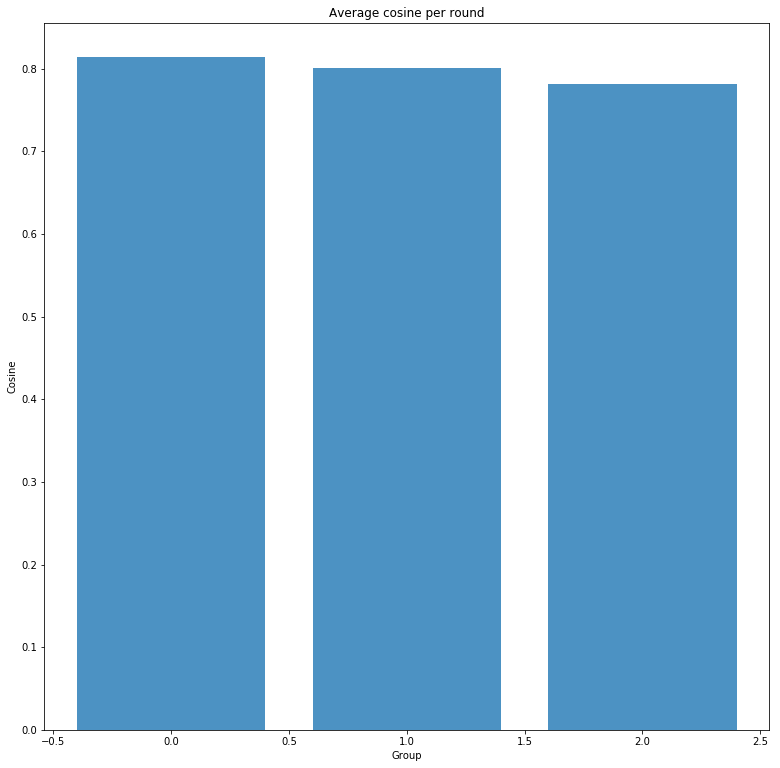

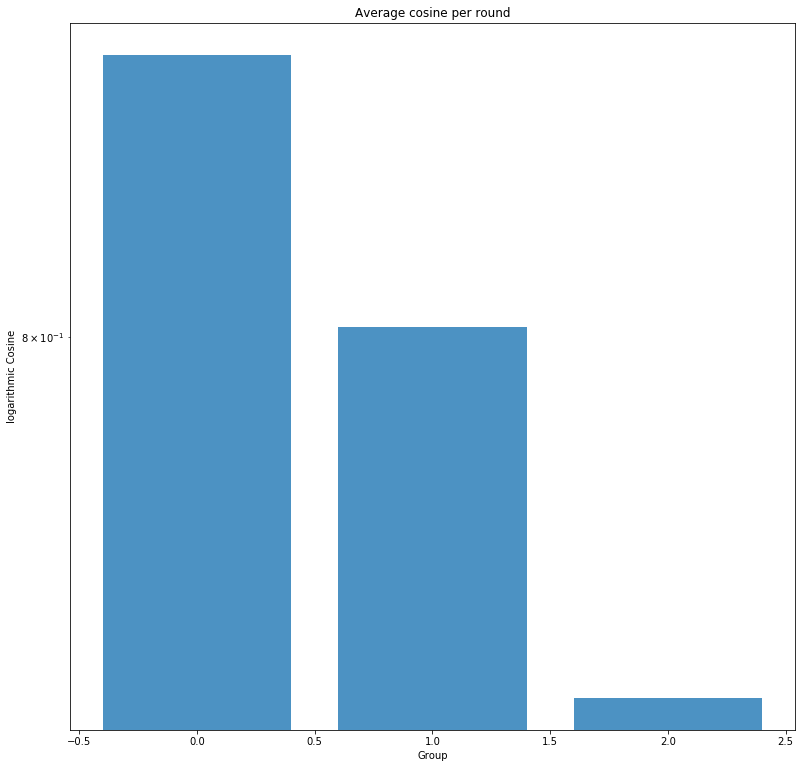

In [198]:
# Cosinus gemiddeld per ronde van alle kids (Casper)
print(level012012.groupby('level', as_index=False)['costheta'].mean())
print(list(level012012.groupby('level', as_index=False)['costheta'].mean()['costheta']))

# get all names and average cosine
names_rounds = list(level012012.groupby('level', as_index=False)['costheta'].mean()['level'])
cos_rounds = list(level012012.groupby('level', as_index=False)['costheta'].mean()['costheta'])

# ik krijg hier gvd geen normale schaalverdeling bij. Ylim werkt niet kutzooi
# er is iig correlatie
plt.bar(names_rounds, cos_rounds, alpha = 0.8)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round.png', dpi=100)
plt.show()


# same with logarithmic scale
plt.bar(names_rounds, cos_rounds, alpha = 0.8, log=True)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('logarithmic Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round_logscale.png', dpi=100)
plt.show()

# Easy diagrams for report

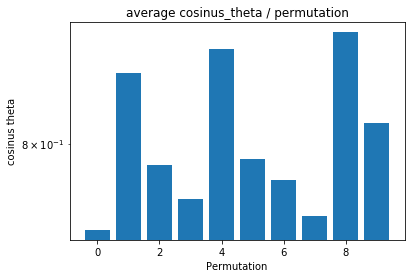

In [11]:
# BAR CHART average cosinus_theta / permutation
permutations = sorted(rr_data['permutation'].unique())

means = []
for p in permutations:
    thispermutation = rr_data.loc[rr_data['permutation'] == p]
    means.append(thispermutation['costheta'].mean())
    
    
plt.bar(permutations, means, log=True)
plt.xlabel('Permutation')
plt.ylabel('cosinus theta')
plt.title('average cosinus_theta / permutation')
plt.savefig('plots/cosine_permutation.png', dpi=100)
plt.show()

In [12]:
## get dataframe with only IDs for Average age
ids = rr_data['ID'].unique()
rr_data_id = rr_data.groupby('ID').first()
ages = list(rr_data_id['age_precise'])
print('The average age of all participants is {}'.format(np.mean(ages)))

percs = list(rr_data_id['mabc_percentile_score'])

The average age of all participants is 7.829102126212949


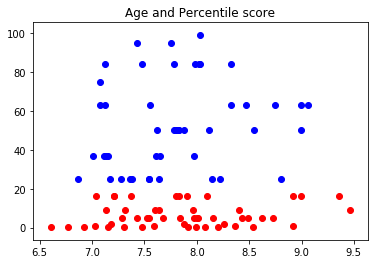

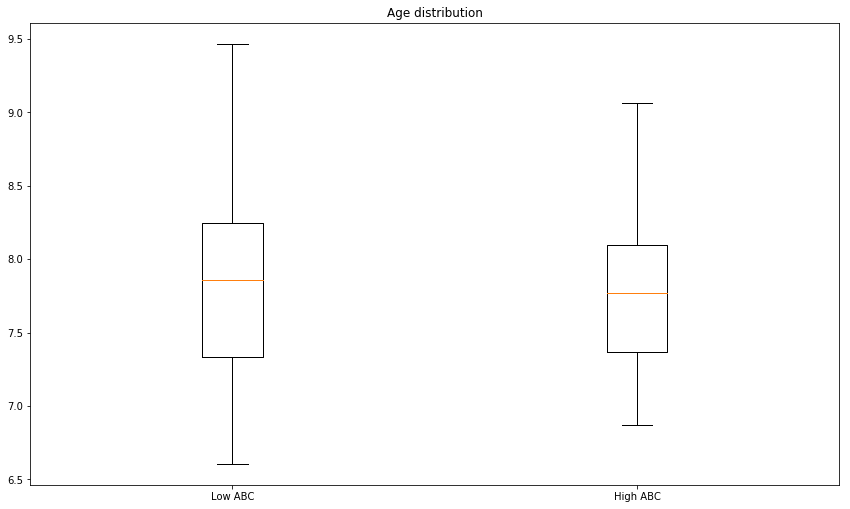

In [13]:
# scatter plot ages
ages_low = []
ages_high = []
for age, perc in zip(ages, percs):
    if perc <= 17:
        ages_low.append(age)
        plt.scatter(age, perc, color='red')
    else:
        ages_high.append(age)
        plt.scatter(age, perc, color='blue')
 
plt.title('Age and Percentile score')
plt.rcParams["figure.figsize"] = (5.5, 12.5)
# uncomment for save
# plt.savefig('plots/scatter_ages.png', dpi=100)
plt.show()
    
# boxplot ages
my_dict = {'Low ABC': ages_low, 'High ABC': ages_high}

fig, ax = plt.subplots()
plt.title('Age distribution')
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
fig.set_size_inches(14.5, 8.5)
# uncomment for save
# fig.savefig('plots/age_percentile.png', dpi=100)



Text(0.5,1,'Gender distribution')

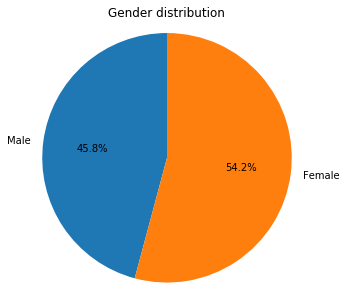

In [14]:
# pie chart of genders
genderlist = list(rr_data_id.groupby('gender').size())
labels = 'Male', 'Female'
plt.rcParams["figure.figsize"] = (5, 5)
fig1, ax1 = plt.subplots()
ax1.pie(genderlist, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Gender distribution')
# uncomment for save:
# fig1.savefig('plots/gender_pie.png', dpi=100)



Text(0.5,1,'mABC test result')

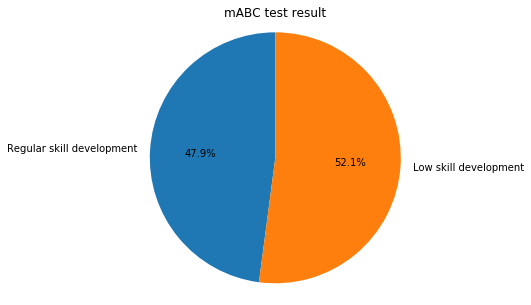

In [15]:
# pie chart of MABC score
abclist = list(rr_data_id.groupby('mabc_binary_score').size())
labels = 'Regular skill development', 'Low skill development'
plt.rcParams["figure.figsize"] = (5, 5)
fig1, ax1 = plt.subplots()
ax1.pie(abclist, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('mABC test result')
# uncomment for save:
# fig1.savefig('plots/mABC_pie.png', dpi=100)

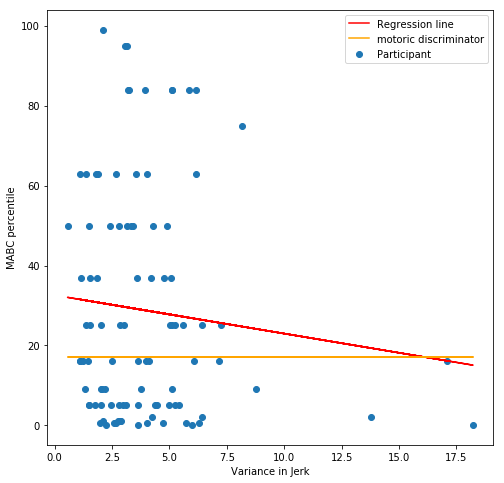

In [16]:
# create a dataframe containing this data
subdata_jerk = rr_data[['ID', 'jerk', 'mabc_percentile_score']]

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_jerk_dictionary = {}
for child_id in children_ids:
    var_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].var()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (var_jerk, mabc_perc)

var_jerk, mabc = dict_to_x_y(subdata_jerk_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(var_jerk, mabc)
var_jerk_slope = [i * slope for i in var_jerk]

# scatter plot with mabc
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(var_jerk, mabc, label='Participant')
plt.plot(var_jerk, intercept + var_jerk_slope, 'r', label='Regression line')
plt.plot(var_jerk, [17 for i in range(len(var_jerk))], 'orange', label='motoric discriminator')
plt.xlabel("Variance in Jerk")
plt.ylabel("MABC percentile")
plt.legend()

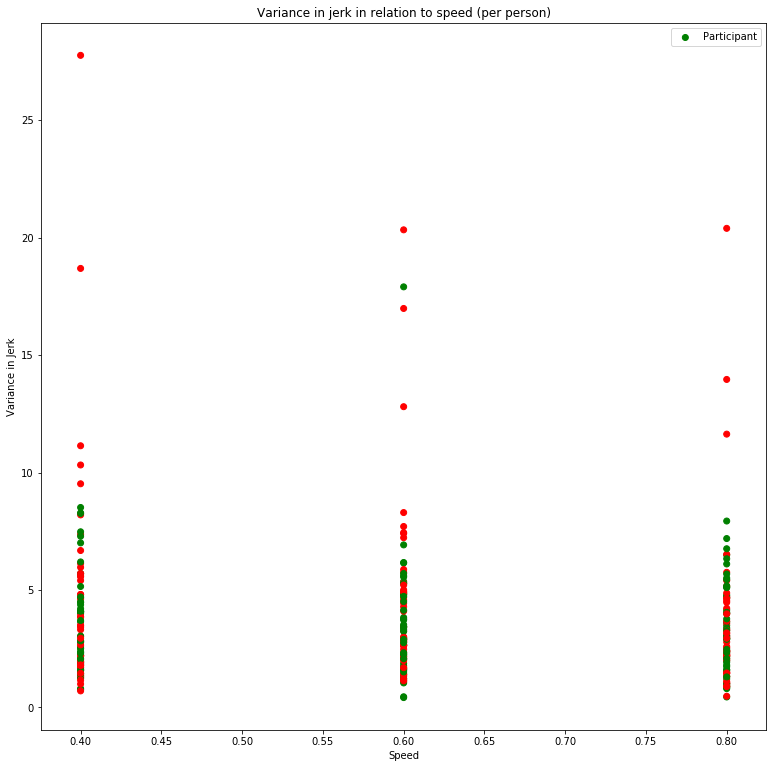

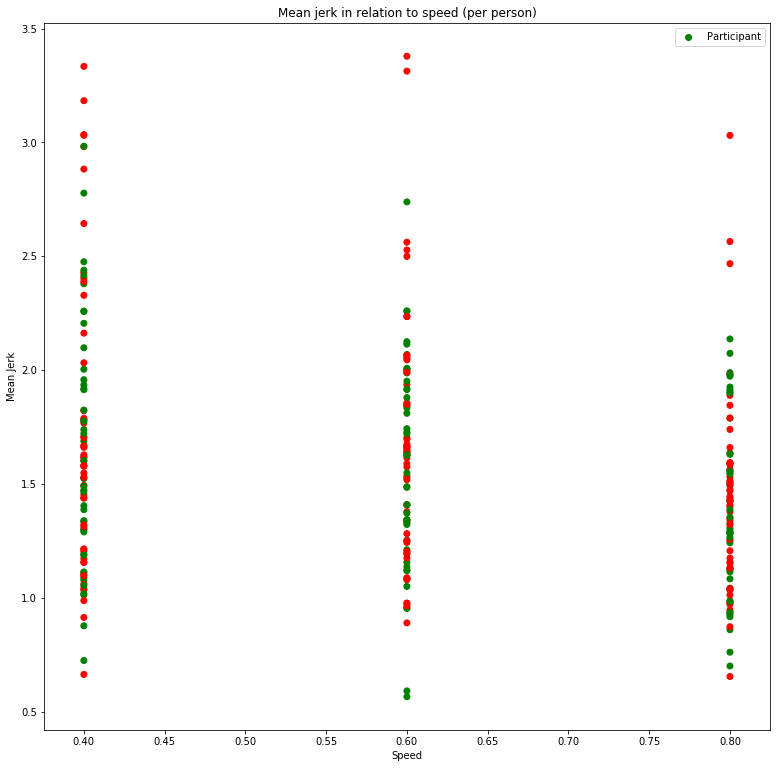

In [17]:
# create a dataframe containing this data
subdata_jerk_speed = rr_data[['ID', 'jerk', 'mabc_binary_score', 'snelheid', 'round']]

speedset = set(subdata_jerk_speed['snelheid'])


subdata_jerk_speed.head(10)


var_jerk_list = []
mean_jerk_list = []
speed_list = []
mabc_list = []

# onderpresterende kinderen reacting to snelheid en jerk
for child_id in children_ids:
    mabc = subdata_jerk_speed.loc[subdata_jerk_speed['ID'] == child_id]['mabc_binary_score'].mean()
    for speed in speedset:
        var_jerk = subdata_jerk_speed.loc[(subdata_jerk_speed['ID'] == child_id) & (subdata_jerk_speed['snelheid'] == speed)]['jerk'].var()
        mean_jerk = subdata_jerk_speed.loc[(subdata_jerk_speed['ID'] == child_id) & (subdata_jerk_speed['snelheid'] == speed)]['jerk'].mean()
#         print(child_id, "has", mean_jerk, var_jerk, " on speed", speed, ". His MABS is:", mabc)
        speed_list.append(speed)
        var_jerk_list.append(var_jerk)
        mean_jerk_list.append(mean_jerk)
        mabc_list.append(mabc)
#     print()

color_list = ['green' if int(i) is 0 else 'red' for i in mabc_list]

plt.rcParams["figure.figsize"] = (13, 13)
plt.scatter(speed_list, var_jerk_list, color=color_list, label='Participant')
plt.title("Variance in jerk in relation to speed (per person)")
plt.legend()
plt.xlabel("Speed")
plt.ylabel("Variance in Jerk")
plt.show()

plt.rcParams["figure.figsize"] = (13, 13)
plt.scatter(speed_list, mean_jerk_list, color=color_list, label='Participant')
plt.title("Mean jerk in relation to speed (per person)")
plt.legend()
plt.xlabel("Speed")
plt.ylabel("Mean Jerk")
plt.show()


     round  costheta
0  level_A  0.840348
1  level_B  0.812286
2  level_C  0.782614
3  level_D  0.783407
4  level_E  0.789382
5  level_F  0.785403
[0.8403480702396885, 0.8122860235096364, 0.7826141749435335, 0.7834074690478088, 0.7893822278971558, 0.7854031804682886]


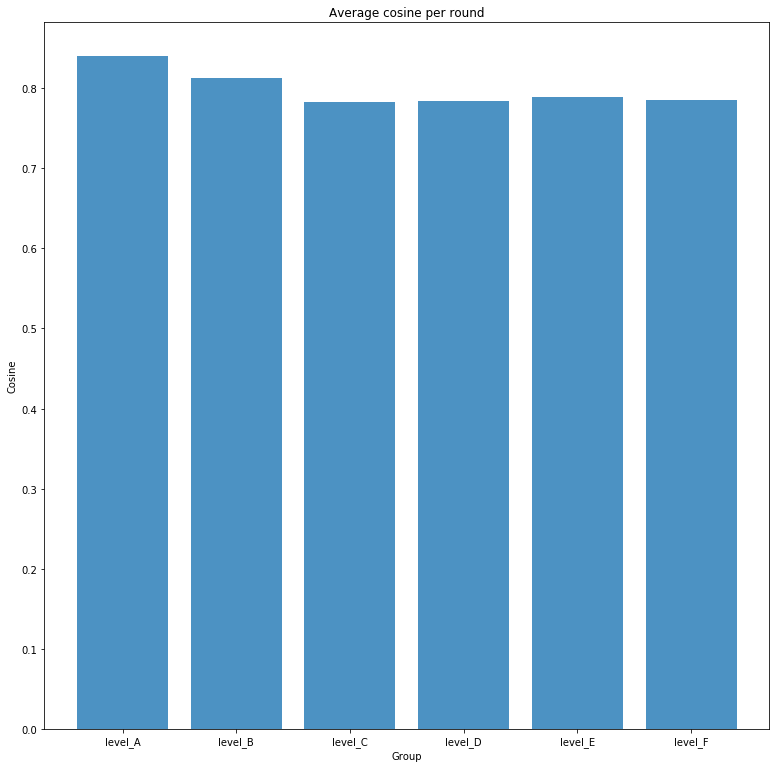

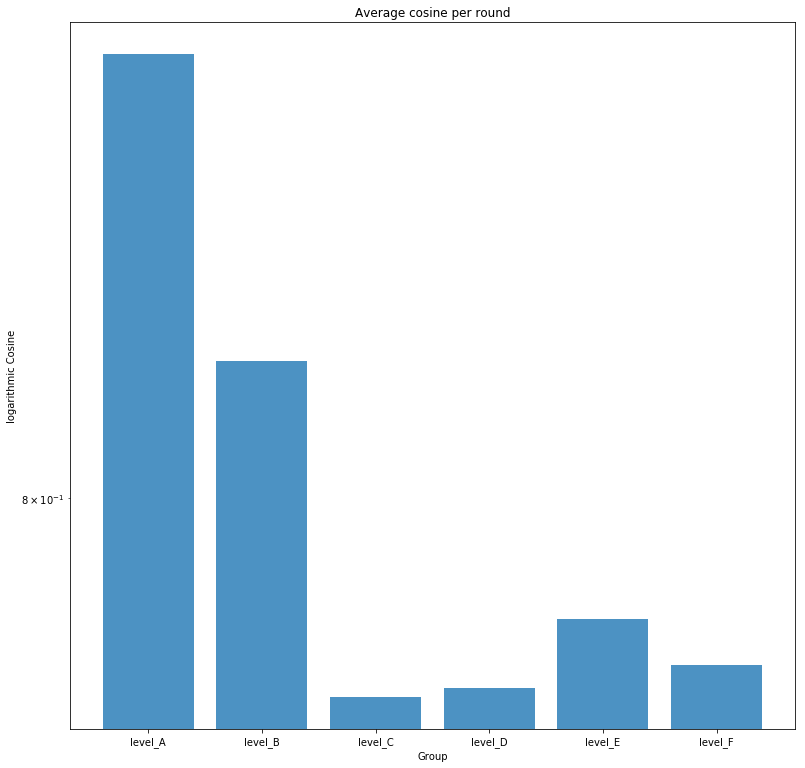

In [18]:
# Cosinus gemiddeld per ronde van alle kids (Casper)
print(rr_data.groupby('round', as_index=False)['costheta'].mean())
print(list(rr_data.groupby('round', as_index=False)['costheta'].mean()['costheta']))

# get all names and average cosine
names_rounds = list(rr_data.groupby('round', as_index=False)['costheta'].mean()['round'])
cos_rounds = list(rr_data.groupby('round', as_index=False)['costheta'].mean()['costheta'])

# ik krijg hier gvd geen normale schaalverdeling bij. Ylim werkt niet kutzooi
# er is iig correlatie
plt.bar(names_rounds, cos_rounds, alpha = 0.8)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round.png', dpi=100)
plt.show()


# same with logarithmic scale
plt.bar(names_rounds, cos_rounds, alpha = 0.8, log=True)
plt.title('Average cosine per round')
plt.xlabel('Group')
plt.ylabel('logarithmic Cosine')
# uncomment for save:
# plt.savefig('plots/avg_cos_per_round_logscale.png', dpi=100)
plt.show()

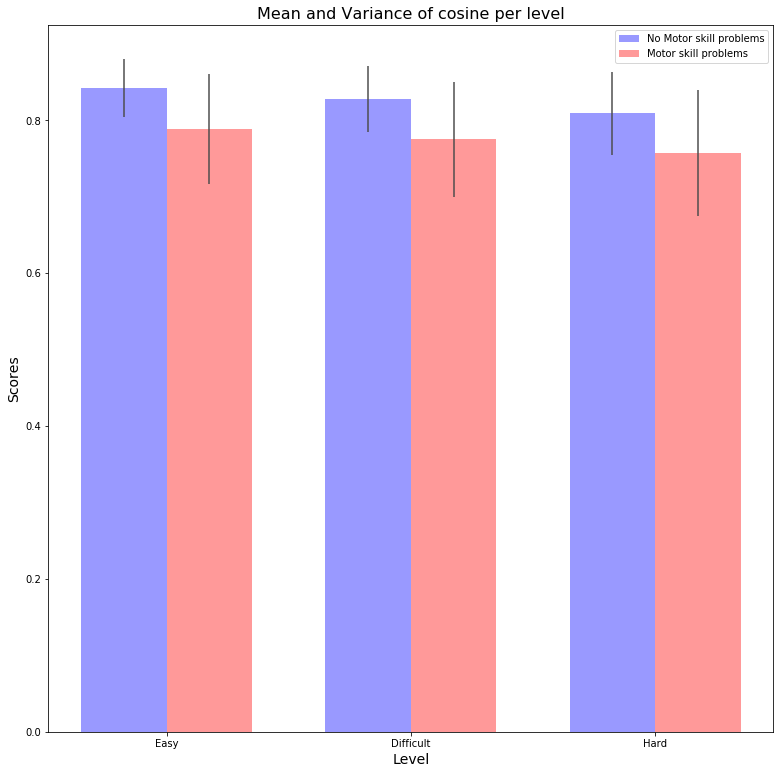

<Figure size 576x432 with 0 Axes>

In [19]:
# drop ID 255
rr_data_dropped = rr_data
rr_data_dropped = rr_data_dropped.drop(rr_data[rr_data.ID == 255].index)

# divide dataset based on mABC score
normaal = rr_data_dropped[rr_data_dropped['mabc_binary_score'] == 0]
gestoord = rr_data_dropped[rr_data_dropped['mabc_binary_score'] == 1]

# get average cosines of normal kids
normaal_avgcos = list(normaal.groupby('level', as_index=False)['costheta'].mean()['costheta'])

# get average cosines of gestoorde kids
gestoord_avgcos = list(gestoord.groupby('level', as_index=False)['costheta'].mean()['costheta'])

# get variance of cosines of normal en gestoorde kids
normaal_var = list(normaal.groupby('level', as_index=False)['costheta'].var()['costheta'])
gestoord_var = list(gestoord.groupby('level', as_index=False)['costheta'].var()['costheta'])

# plot beautiful barchart
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

n_groups = 3
fig, ax = plt.subplots()
plt.figure(figsize=(8,6))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, normaal_avgcos, bar_width,
                alpha=opacity, color='b',
                yerr=normaal_var, error_kw=error_config,
                label='No Motor skill problems')

rects2 = ax.bar(index + bar_width, gestoord_avgcos, bar_width,
                alpha=opacity, color='r',
                yerr=gestoord_var, error_kw=error_config,
                label='Motor skill problems')

ax.set_xlabel('Level', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Mean and Variance of cosine per level', fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Easy', 'Difficult', 'Hard'))
ax.legend()
# uncomment for save
# fig.savefig('plots/mean_var_cos_per_level.png', dpi=100)

plt.show()

The average of children without motor skill problems : 0.2940828632338094
The average of children with motor skill problems : 0.3221141618978073
this is pretty close...


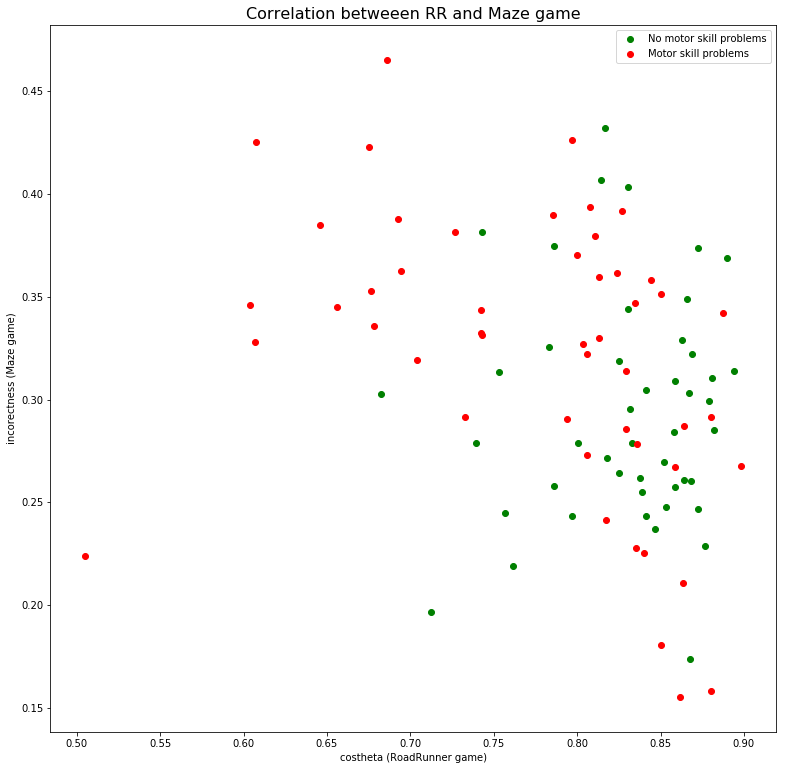

In [20]:
# difference Roadrunner en maze lilcasp
# avg costheta roadrunner participants
rr_costheta_normaal = list((normaal.groupby('ID', as_index=False)['costheta'].mean()['costheta']))
rr_costheta_gestoord = list((gestoord.groupby('ID', as_index=False)['costheta'].mean()['costheta']))

# split data of maze 
normaal_m = m_data[m_data['mabc_binary_score'] == 0]
gestoord_m = m_data[m_data['mabc_binary_score'] == 1]

m_incorrect_normaal = list((normaal_m.groupby('ID', as_index=False)['incorrect'].mean()['incorrect']))
m_incorrect_gestoord = list((gestoord_m.groupby('ID', as_index=False)['incorrect'].mean()['incorrect']))

print('The average of children without motor skill problems : {}'.format(np.mean(m_incorrect_normaal)))
print('The average of children with motor skill problems : {}'.format(np.mean(m_incorrect_gestoord)))
print('this is pretty close...')

# plot this babe
plt.scatter(rr_costheta_normaal, m_incorrect_normaal, color='green', label='No motor skill problems')
plt.scatter(rr_costheta_gestoord, m_incorrect_gestoord, color='red', label='Motor skill problems')
plt.title('Correlation betweeen RR and Maze game', fontsize=16)
plt.xlabel('costheta (RoadRunner game)')
plt.ylabel('incorectness (Maze game)')
plt.legend()
# plt.savefig('plots/correlation_RR_M.png', dpi=100)
plt.show()

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error

clf = GaussianNB()
clf.fit(X, Y)

NameError: name 'X' is not defined

In [22]:

# shuffle this list
shuffled_kids = random.sample(list(children_ids), len(list(children_ids)))

# 56 kinderen training
# 20 kinderen
# 20 kinderen
training_kids = shuffled_kids[:56]
val_kids = shuffled_kids[56:76]
testing_kids = shuffled_kids[76:96]

rr_training_data = rr_data.loc[rr_data['ID'].isin(training_kids)]
rr_val_data = rr_data.loc[rr_data['ID'].isin(val_kids)]
rr_testing_data = rr_data.loc[rr_data['ID'].isin(testing_kids)]



In [27]:
mabc_dictionary = {}

for child_id in children_ids:
    mabc = int(rr_data.loc[subdata['ID'] == child_id]['mabc_binary_score'].mean())
    mean_ct = round(rr_data.loc[subdata['ID'] == child_id]['costheta'].mean(),4)
    mabc_dictionary[child_id] = (mean_ct, mabc)
    
print(mabc_dictionary)

{101: (0.8305, 0), 102: (0.6947, 1), 103: (0.505, 1), 104: (0.8632, 0), 105: (0.844, 1), 107: (0.7429, 0), 109: (0.6751, 1), 110: (0.6765, 1), 111: (0.7859, 0), 113: (0.8143, 0), 115: (0.7967, 0), 116: (0.7424, 1), 118: (0.8643, 1), 119: (0.8134, 1), 120: (0.7268, 1), 121: (0.806, 1), 130: (0.6073, 1), 131: (0.8878, 1), 132: (0.6822, 0), 133: (0.7857, 1), 134: (0.8533, 0), 135: (0.6037, 1), 136: (0.7568, 0), 190: (0.8672, 0), 191: (0.8901, 0), 192: (0.8586, 1), 193: (0.8272, 1), 195: (0.8326, 0), 196: (0.794, 1), 197: (0.866, 0), 199: (0.8615, 1), 200: (0.8589, 0), 201: (0.656, 1), 203: (0.8314, 0), 205: (0.8058, 1), 207: (0.646, 1), 208: (0.8809, 0), 220: (0.8984, 1), 221: (0.8506, 1), 222: (0.8504, 1), 223: (0.7421, 1), 225: (0.8943, 0), 226: (0.8582, 0), 229: (0.8637, 1), 230: (0.786, 0), 231: (0.8819, 0), 233: (0.8251, 0), 234: (0.8803, 1), 235: (0.6928, 1), 236: (0.7121, 0), 237: (0.8106, 1), 251: (0.8727, 0), 254: (0.824, 1), 255: (0.7459, 1), 302: (0.8007, 0), 304: (0.8351, 1), 

In [65]:
X, Y = dict_to_x_y(mabc_dictionary)
X = np.array(X)
Y = np.array(Y)
print(Y)

print(len(X))
n_samples = len(X)
n_features = 1



[0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0
 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0
 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0]
96


In [86]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np






X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]


X_train = X[:48]
y_train = Y[:48]
X_test = X[48:]
y_test = Y[48:]


# Create a simple classifier
classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

In [87]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.49


Text(0.5,1,'2-class Precision-Recall curve: AP=0.49')

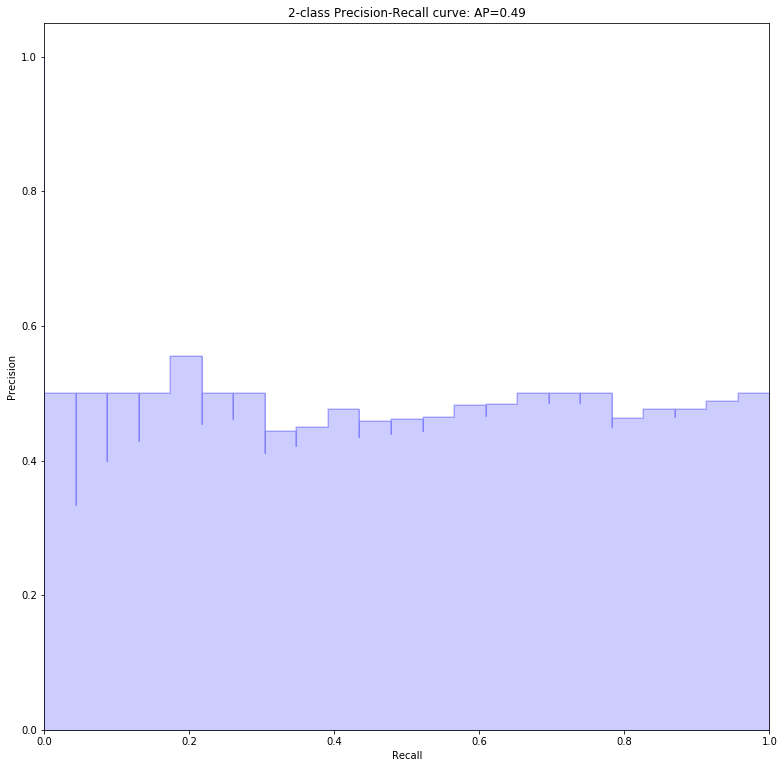

In [88]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))